In [22]:
# import system modules
import sys
import os
import gc

# import standard numerical modules
import numpy as np
import math

import matplotlib.pyplot as plt

# import machine learning modules
import tensorflow as tf
import keras.backend as K

sys.path.append('../20240503')
import DCTR


# Process Data

In [23]:
data_dir = '../../Data'
num_events = 100000


In [29]:
# load datasets created in commented out cells above ^
# and n-jettiness datasets created with python scripts on NAF
X0_showered = np.load(f'{data_dir}/POWHEG_hvq/all_decays_filtered/converted_lhe_hvq_all_decays_filtered.npy')[:num_events]

# nrm data and save to disk (only needed to run once)
'''
nrm_array_dir = '/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/Data/POWHEG_hvq/showered/'
nrm_array = np.load(f'{nrm_array_dir}/norm_array_lhe_01.npy')
X0_nrm, _ = DCTR.normalize_data(X0_showered.copy(), nrm_array)
np.save(f'{data_dir}/POWHEG_hvq/all_decays_filtered/normed_lhe_hvq_all_decays_filtered.npy', X0_nrm)
'''
X0_nrm = np.array(np.load(f'{data_dir}/POWHEG_hvq/all_decays_filtered/normed_lhe_hvq_all_decays_filtered.npy')[:num_events])

X0_nJets = np.array(np.load(f'{data_dir}/POWHEG_hvq/all_decays_filtered/jet_multiplicity_hvq_all_decays_filtered.npy')[:num_events])
X0_wgt = X0_nJets[:,1]

X0_jet = np.array(np.load(f'{data_dir}/POWHEG_hvq/all_decays_filtered/jet_4vectors_hvq_all_decays_filtered.npy'))


print(f'{np.shape(X0_showered)  = }')
print(f'{np.shape(X0_nrm)       = }')
print(f'{np.shape(X0_nJets)     = }')
print(f'{np.shape(X0_wgt)       = }')
print(f'{np.shape(X0_jet)       = }')


np.shape(X0_showered)  = (100000, 3, 9)
np.shape(X0_nrm)       = (100000, 3, 9)
np.shape(X0_nJets)     = (100000, 2)
np.shape(X0_wgt)       = (100000,)
np.shape(X0_jet)       = (100000, 20, 6)


In [30]:
# MiNNLO | only 10k events per lhe

X1_showered = []
X1_nJets = []
X1_jet = []
for i in range(11):
    X1_showered.extend(np.load(f'{data_dir}/MiNNLO/showered/converted_lhe_MiNNLO_{990 + i:04d}.npy'))
    X1_nJets.extend(np.load(f'{data_dir}/MiNNLO/showered/jet_multiplicity_MiNNLO_{990 + i:04d}.npy'))
    X1_jet.extend(np.load(f'{data_dir}/MiNNLO/showered/jet_4vectors_MiNNLO_{990 + i:04d}.npy'))


X1_showered = np.array(X1_showered[:num_events])
X1_nJets = np.array(X1_nJets[:num_events])
X1_jet = np.array(X1_jet[:num_events])

X1_wgt = X1_nJets[0:100000, 1]


print(f'{np.shape(X1_showered)  = }')
print(f'{np.shape(X1_nJets)     = }')
print(f'{np.shape(X1_wgt)       = }')
print(f'{np.shape(X1_jet)       = }')


np.shape(X1_showered)  = (100000, 3, 9)
np.shape(X1_nJets)     = (100000, 2)
np.shape(X1_wgt)       = (100000,)
np.shape(X1_jet)       = (100000, 20, 6)


In [31]:
print(f'{(X0_nJets[:20])     = }')

print(f'{(X1_nJets[:20])     = }')


(X0_nJets[:20])     = array([[  4.   , 692.015],
       [  3.   , 692.015],
       [  5.   , 692.015],
       [  4.   , 692.015],
       [  7.   , 692.015],
       [  1.   , 692.015],
       [  3.   , 692.015],
       [  3.   , 692.015],
       [  3.   , 692.015],
       [  2.   , 692.015],
       [  4.   , 692.015],
       [  4.   , 692.015],
       [  5.   , 692.015],
       [  6.   , 692.015],
       [  6.   , 692.015],
       [  3.   , 692.015],
       [  4.   , 692.015],
       [  5.   , 692.015],
       [  4.   , 692.015],
       [  5.   , 692.015]])
(X1_nJets[:20])     = array([[   3.   ,  103.245],
       [   2.   ,  103.245],
       [   5.   , -103.245],
       [   1.   ,  103.245],
       [   3.   ,  103.245],
       [   3.   ,  103.245],
       [   2.   ,  103.245],
       [   5.   ,  103.245],
       [   1.   ,  103.245],
       [   3.   ,  103.245],
       [   2.   ,  103.245],
       [   3.   ,  103.245],
       [   3.   ,  103.245],
       [   6.   , -103.245],
       [ 

In [32]:
# delete energy from (normalized) testing dataset, since the neural network was trained without these parameters
X0_nrm = np.delete(X0_nrm, 5, -1) # E
X0_nrm = np.delete(X0_nrm, 4, -1) # eta
# garbage collection after deleting to clear memory asap
print(gc.collect())


14061


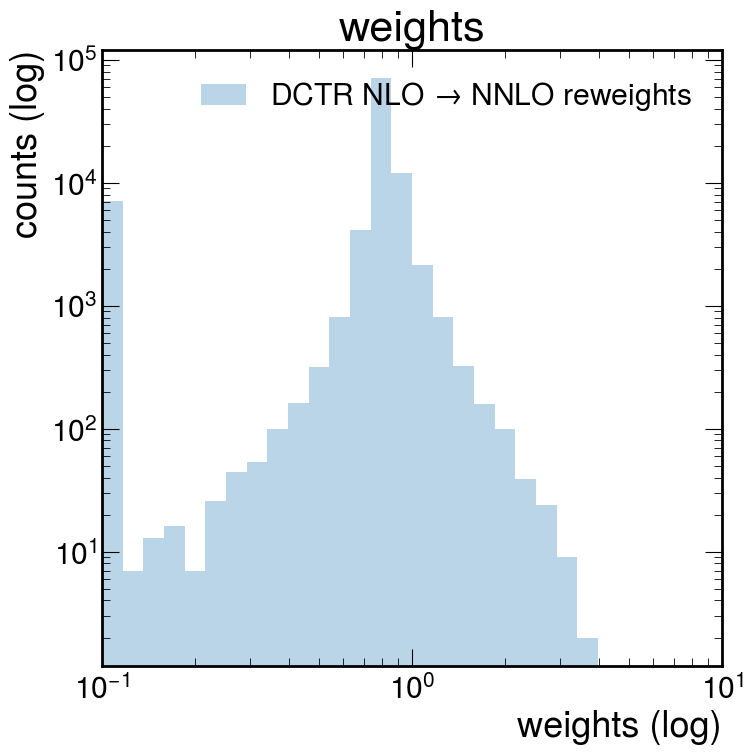

In [35]:
# get rwgt and compare hvq before and after rwgt


# calculate weights from DCTR
model = '../20240521_showered_new/train_20240522/super_epoch_6/run_0/s-6_b-131072_r-0.tf' # path to previously trained model (in .tf format (folder)) for showered events


# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], X0_nrm) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook
# plot and check dctr rwgt
wgts_plot = [(dctr_rwgt[0], r'DCTR NLO $\to$ NNLO reweights')]
DCTR.plot_weights(wgts_plot, start = 0.1, stop = 10)

# apply orginal generator weights to rwgt
rwgt = np.multiply(dctr_rwgt[0], X0_wgt)


In [36]:
print(X1_wgt)
print(X0_wgt)

print(rwgt)


[ 103.245  103.245 -103.245 ...  103.245  103.245  103.245]
[692.015 692.015 692.015 ... 692.015 692.015 692.015]
[553.86803029 547.28281503 494.88792676 ... 512.48761697 598.21119651
 532.97123649]


In [37]:
print(np.shape(X1_nJets))
print(np.shape(X1_wgt))

print(np.shape(X0_nJets))
print(np.shape(X0_wgt))

print(np.shape(rwgt))

(100000, 2)
(100000,)
(100000, 2)
(100000,)
(100000,)


# jet multiplicity


/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1393: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1394: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
/home/finn/DCTR_Paper/DCTR_FP/20240603_shower_jets/../20240503/DCTR.py:1395: RuntimeWarning: invalid value encountered in true_divide
  ratio_2 = hist2 / hist0
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


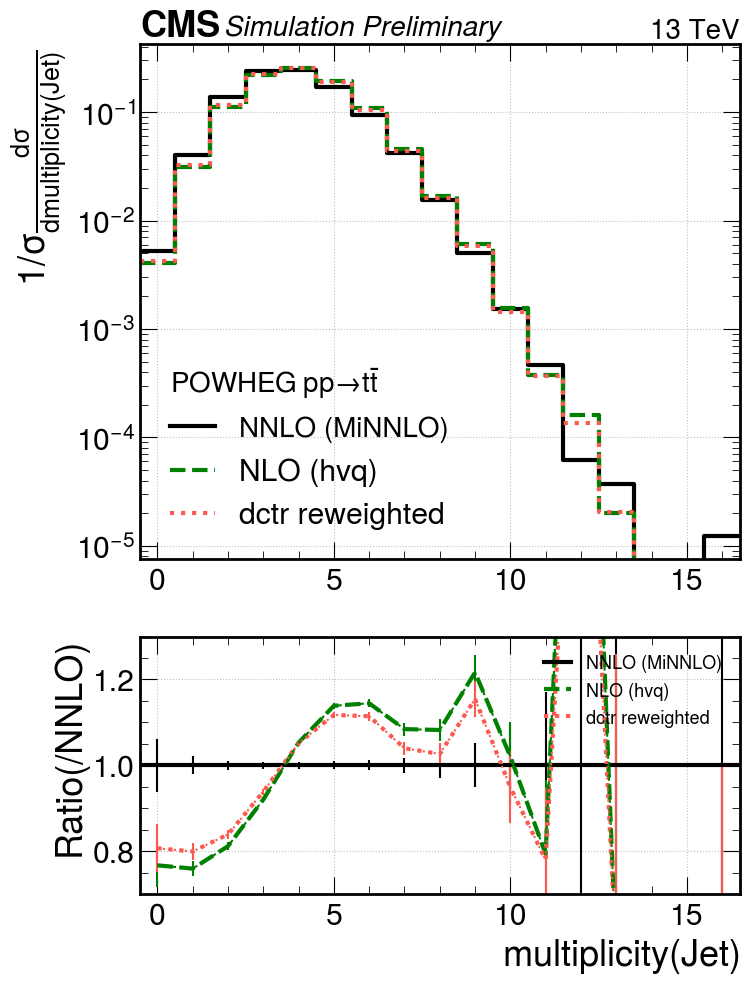

In [44]:
args_multiplicity = [(X1_nJets[:,0], X1_wgt, 'NNLO (MiNNLO)'),
                     (X0_nJets[:,0], X0_wgt, 'NLO (hvq)'),
                     (X0_nJets[:,0], rwgt, 'dctr reweighted')]


bins = np.linspace(-0.5, 16.5, 18)


DCTR.plot_ratio_cms(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


In [58]:
# compare to non filtered hvq
X0_plt = []
X0_plt = np.load(f'{data_dir}/POWHEG_hvq/showered/converted_lhe_03.npy')[:num_events] # 9543943 num of MiNNLO samples
print('POWHEG hvq all particles X0_plt.shape: '+str(X0_plt.shape))

X0_test = []
X0_test = np.load(f'{data_dir}/POWHEG_hvq/showered/normed_lhe_03.npy')[:num_events]
print('POWHEG hvq all particles X0_test.shape: '+str(X0_test.shape))

X0_plt_wgt = X0_plt[:, 0, 7].copy()

print(X0_plt_wgt)


POWHEG hvq all particles X0_plt.shape: (100000, 3, 9)
POWHEG hvq all particles X0_test.shape: (100000, 3, 9)
[692.452 692.452 692.452 ... 692.452 692.452 692.452]


In [59]:
# MiNNLO
# plotting data
X1_plt = []
X1_plt = np.load(f'{data_dir}/MiNNLO/showered/converted_lhe.npy')[:num_events]
print(f'{np.shape(X1_plt) = }')

X1_nrm = []
X1_nrm = np.load(f'{data_dir}/MiNNLO/showered/normed_lhe.npy')[:num_events]
print(f'{np.shape(X1_nrm) = }')


np.shape(X1_plt) = (100000, 3, 9)
np.shape(X1_nrm) = (100000, 3, 9)


In [60]:
# get event generator weights

X0_plt_wgt = X0_plt[:, 0, 7].copy()
X1_plt_wgt = X1_plt[:, 0, 7].copy()
X1_nrm_wgt = X1_nrm[:, 0, 7].copy()

print(X0_plt_wgt)
print(X1_plt_wgt)
print(X1_nrm_wgt)


[692.452 692.452 692.452 ... 692.452 692.452 692.452]
[-103.245  103.245 -103.245 ... -103.245  103.245  103.245]
[-1.  1. -1. ... -1.  1.  1.]


In [61]:
# delete energy from (normalized) testing dataset, since the neural network was trained without these parameters
X0_test = np.delete(X0_test, 5, -1)

# delete eta
X0_test = np.delete(X0_test, 4, -1)

# garbage collection after deleting to clear memory asap
print(gc.collect())


16507


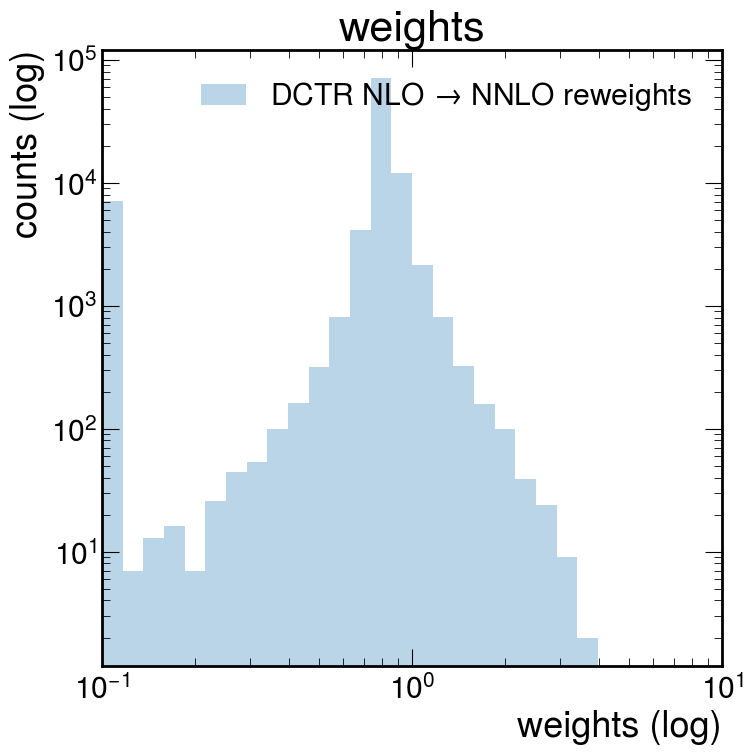

In [62]:
# calculate weights from DCTR
model = '../20240521_showered_new/train_20240522/super_epoch_6/run_0/s-6_b-131072_r-0.tf' # path to previously trained model (in .tf format (folder)) for showered events

# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt_test = DCTR.get_rwgt([model], X0_test) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook
# plot and check dctr rwgt
wgts_plot_test = [(dctr_rwgt[0], r'DCTR NLO $\to$ NNLO reweights')]
DCTR.plot_weights(wgts_plot_test, start = 0.1, stop = 10)

# apply orginal generator weights to rwgt
rwgt_test = np.multiply(dctr_rwgt[0], X0_plt_wgt)


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


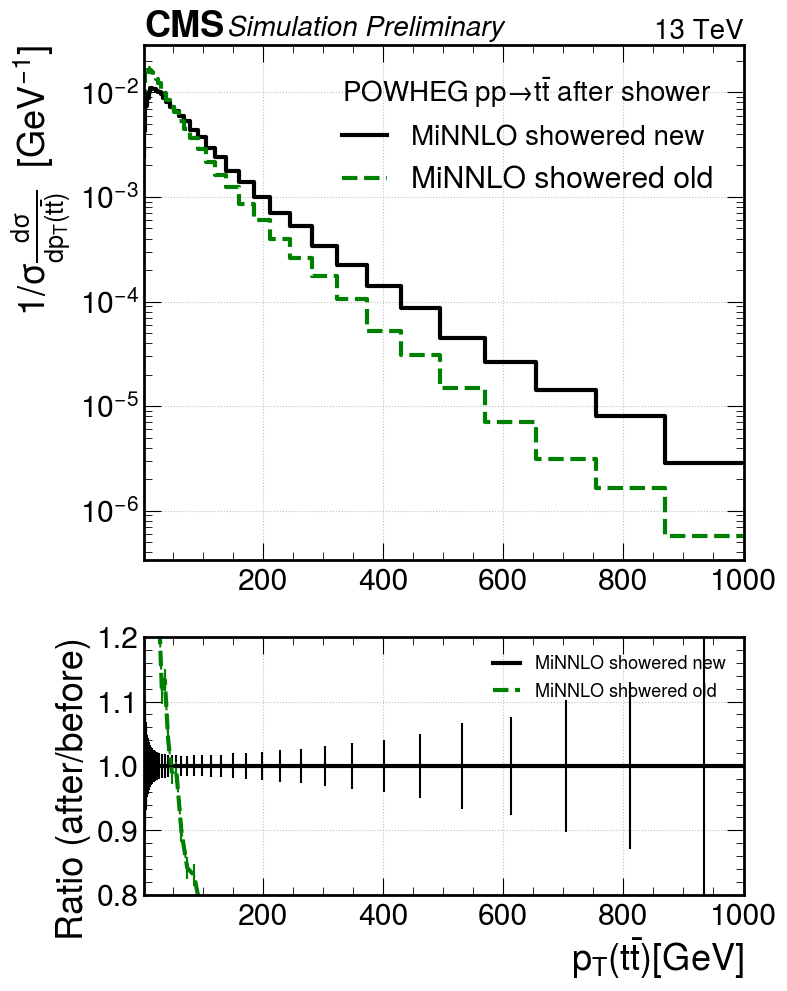

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


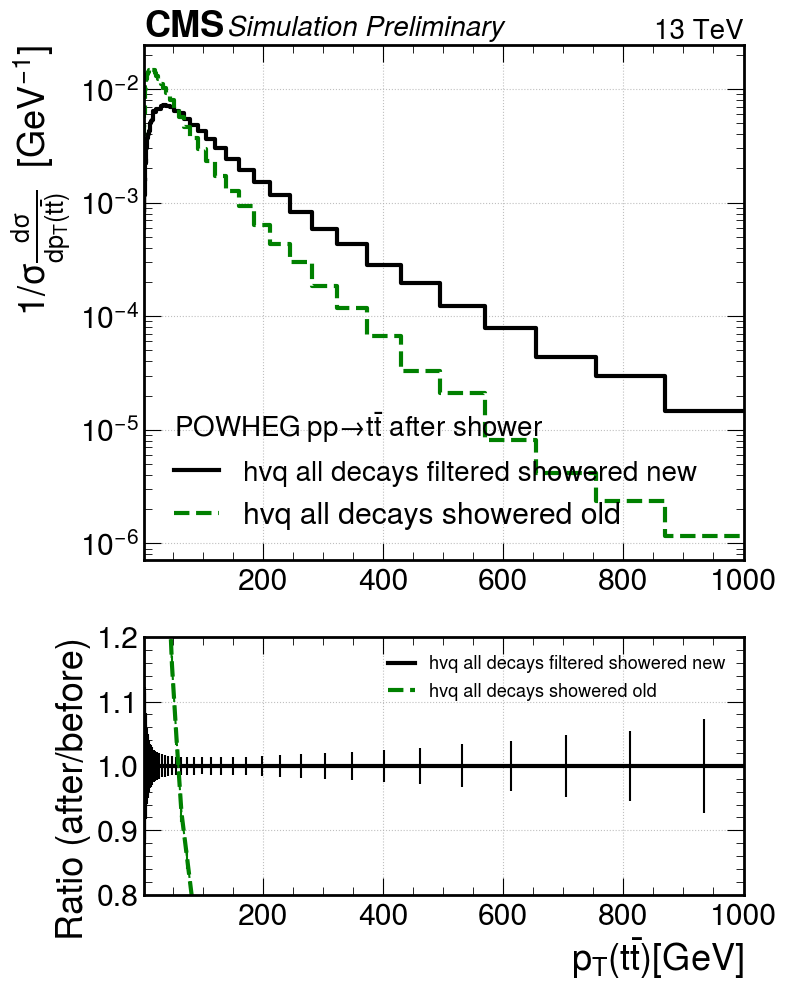

In [66]:
args_test = [(X1_showered, X1_wgt, 'MiNNLO showered new'),
             (X1_plt, X1_plt_wgt, 'MiNNLO showered old')]#,
             #(X0_plt, X0_wgt, 'hvq all decays showered'),
             #(X0_plt, rwgt_test, 'dctr reweight hvq -> MiNNLO')]

log_bins = np.logspace(np.log10(1), np.log10(1000), 50)
DCTR.plot_ratio_cms_2(args_test, arg_index=0, part_index=0, bins=log_bins, y_scale='log', ratio_ylim=[0.8, 1.2], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_log_0800_31')


args_test = [# (X1_showered, X1_wgt, 'MiNNLO showered new'),
             # (X1_plt, X1_plt_wgt, 'MiNNLO showered old')]#,
             (X0_showered, X0_wgt, 'hvq all decays filtered showered new'),
             (X0_plt, X0_plt_wgt, 'hvq all decays showered old')]

log_bins = np.logspace(np.log10(1), np.log10(1000), 50)
DCTR.plot_ratio_cms_2(args_test, arg_index=0, part_index=0, bins=log_bins, y_scale='log', ratio_ylim=[0.8, 1.2], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_log_0800_31')


# jet p_t

In [ ]:
log_bins = np.logspace(np.log10(30), np.log10(1000), 31)

args_jet_0 = [(X1_jet[:, 0, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 0, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 0, 0], rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_0, bins = log_bins, y_scale = 'log', part_label='1. Jet', ratio_ylim=(0.7, 1.3))


args_jet_1 = [(X1_jet[:, 1, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 1, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 1, 0], rwgt, 'dctr reweighted')]

# DCTR.plot_ratio_cms(args_jet_1, bins = log_bins, y_scale = 'log', part_label='2. Jet')


args_jet_2 = [(X1_jet[:, 2, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 2, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 2, 0], rwgt, 'dctr reweighted')]

# DCTR.plot_ratio_cms(args_jet_2, bins = log_bins, y_scale = 'log', part_label='3. Jet')


args_jet_3 = [(X1_jet[:, 3, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 3, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 3, 0], rwgt, 'dctr reweighted')]

# DCTR.plot_ratio_cms(args_jet_3, bins = log_bins, y_scale = 'log', part_label='4. Jet')


In [ ]:
# sum of jet pt per event

X0_jet_pt_sums = []
for event in X0_jet:
    X0_jet_pt_sums.append(np.sum(event[:,0]))

X1_jet_pt_sums = []
for event in X1_jet:
    X1_jet_pt_sums.append(np.sum(event[:,0]))

    
print(f'{np.shape(X0_jet_pt_sums) = }')
print(f'{np.shape(X1_jet_pt_sums) = }')

log_bins = np.logspace(np.log10(10), np.log10(1000), 31)

args_jet_sum = [(np.array(X1_jet_pt_sums), X1_wgt, 'NNLO (MiNNLO)'),
                (np.array(X0_jet_pt_sums), X0_wgt, 'NLO (hvq)'),
                (np.array(X0_jet_pt_sums), rwgt, 'dctr reweighted')]

log_bins = np.logspace(np.log10(30), np.log10(1000), 31)

DCTR.plot_ratio_cms(args_jet_sum, bins = log_bins, y_scale = 'log', part_label='Sum of Jets', ratio_ylim=(0.7, 1.3))


